# Spatial evolutionary game simulator

S. Kolotev, A. Malyutin, E. Burovski, S. Krashakov and L. Shchur, *Dynamic fractals in spatial evolutionary games*, Physica A **499**, 142 (2018)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation

%matplotlib notebook

In [4]:
import sys
import cython

print("python ", sys.version)
print("numpy", np.__version__, ", matplotlib", mpl.__version__, ", and Cython", cython.__version__)

python  3.5.2 (default, Nov 17 2016, 17:05:23) 
[GCC 5.4.0 20160609]
numpy 1.18.5 , matplotlib 2.0.2 , and Cython 0.29.20


## Main update function:

In [5]:
def evolve2(field, b, num_steps=1):
    L = field.shape[0]
    current = np.zeros((L, L), dtype=int)
    scores = np.zeros((L, L), dtype=float)
    
    for step in range(num_steps):
        current = field.copy()
        scores = np.zeros((L, L), dtype=float)
        
        for x in range(L):
            for y in range(L):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        scores[x, y] += (1 - field[ix, jy])
                        
                if field[x, y] == 1:
                    scores[x, y] *= b
        
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        if (scores[bestX, bestY] < scores[ix, jy]):
                            bestX = ix
                            bestY = jy
                
                field[x, y] = current[bestX, bestY]
    return field

### Run the simulation and animate

<IPython.core.display.Javascript object>


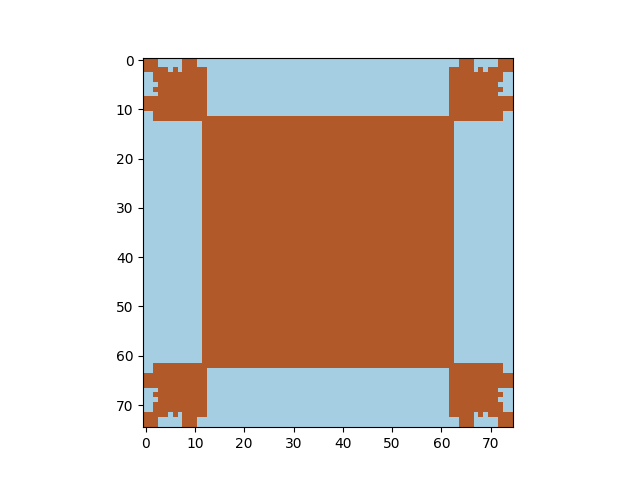

In [6]:
L = 75
field = np.zeros((L, L), dtype=int)
field[L//2, L//2] = 1

# draw the initial field
fig = plt.figure()
im = plt.imshow(field, animated=True, cmap=plt.get_cmap('Paired'))

# updater function
def updatefig(*args):
    global field
    field = evolve2(field, 1.81, 1)
    im.set_array(field)
    return im,

# animate!
anim = animation.FuncAnimation(fig, updatefig, frames=200, interval=50, blit=True)

plt.show()

### Timings

In [7]:
L = 44
field = np.zeros((L, L), dtype=int)
field[L//2, L//2] = 1

%timeit evolve2(field, 1.81, 10)

466 ms ± 7.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Enter Cython

In class, we started with the original code and did the conversion iteratively, removing yellow lines from the annotated output. Below is only the final result.

In [8]:
%load_ext cython

In [9]:
%%cython -a

import numpy as np

import cython

@cython.cdivision(True)
@cython.boundscheck(False)
def evolve2_1(long[:, ::1] field, double b, int num_steps=1):
    
    cdef int x, y, L, i, j, ix, jy, step
    
    L = field.shape[0]
    cdef double[:, ::1] scores = np.zeros((L, L), dtype=float)
    
    cdef double[:, ::1] _zeros = np.zeros((L, L), dtype=float)
    cdef long[:, ::1] current = field.copy()
    
    for step in range(num_steps):
        current = field.copy()
        scores[...] = _zeros
        
        for x in range(L):
            for y in range(L):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        scores[x, y] += (1 - field[ix, jy])
                        
                if field[x, y] == 1:
                    scores[x, y] *= b
        
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        if (scores[bestX, bestY] < scores[ix, jy]):
                            bestX = ix
                            bestY = jy
                
                field[x, y] = current[bestX, bestY]
    return field

In [10]:
L = 44
field = np.zeros((L, L), dtype=int)
field[L//2, L//2] = 1

%timeit evolve2_1(field, 1.81, 10)

2.34 ms ± 61.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
466 / 2.34

199.14529914529916

The recommended code structure is to have a python-facing `def` function which takes care of the input and output, allocated memory etc, and delegates all heavy lifting to an internal `cdef` function.

In [ ]:
%%cython -a

import numpy as np
import cython

def evolve2_2(field, b, num_steps=1):
    # validate input here
    field = np.atleast_2d(field)
    # XXX check that field is integer dtype etc
    
    # allocate memory here
    L = field.shape[0]
    scores = np.zeros((L, L), dtype=float)
    current = field.copy()
    _zeros = np.zeros((L, L), dtype=float)

    cdef:
        int _num_steps = num_steps
        double _b = b
    
    # do the work (`field` array is updated in-place)
    _evolve2_2_impl(field, _b, _num_steps, scores, _zeros, current)
    
    # convert memoryviews to numpy arrays
    return np.asarray(field)


@cython.cdivision(True)
@cython.boundscheck(False)
cdef void _evolve2_2_impl(long[:, ::1] field, double b, int num_steps,
                                  double[:, ::1] scores, double[:, ::1] _zeros,
                                  long[:, ::1] current) nogil:
    
    cdef int x, y, L, i, j, ix, jy, step
    
    L = field.shape[0]

    for step in range(num_steps):
        current[...] = field
        scores[...] = _zeros
        
        for x in range(L):
            for y in range(L):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        scores[x, y] += (1 - field[ix, jy])
                        
                if field[x, y] == 1:
                    scores[x, y] *= b
        
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        if (scores[bestX, bestY] < scores[ix, jy]):
                            bestX = ix
                            bestY = jy
                
                field[x, y] = current[bestX, bestY]

# Turn on OpenMP parallelism

In [13]:
%%cython -a --compile-args=-fopenmp --link-args=-fopenmp

# note the compile/link args

import numpy as np
cimport cython

from cython.parallel cimport prange     # prange

@cython.boundscheck(False)
@cython.cdivision(True)
def evolve2_3(long[:, ::1] field, float b, int num_steps=1):
    
    cdef int x, y, L, i, j, ix, iy, jx, jy, step, bestX, bestY
    
    L = field.shape[0]
    cdef double[:, ::1] _zeros = np.zeros((L, L), dtype=float)
    cdef double[:, ::1] scores = np.zeros((L, L), dtype=float)
    
    cdef long[:, ::1] current = np.zeros((L, L), dtype=int)
    
    for step in range(num_steps):
        current = field.copy()
        scores[...] = _zeros
 
        with nogil:
            for x in prange(L):                # prange in a nogil section
                for y in range(L):             # only prange the outer loop
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            ix = (x + i) % L
                            jy = (y + j) % L
                            scores[x, y] += (1 - field[ix, jy])

                    if field[x, y] == 1:
                        scores[x, y] *= b

            for x in prange(L):                 # prange in a nogil section
                for y in range(L):
                    bestX = x
                    bestY = y
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            ix = (x + i) % L
                            jy = (y + j) % L
                            if (scores[bestX, bestY] < scores[ix, jy]):
                                bestX = ix
                                bestY = jy
                    field[x, y] = current[bestX, bestY]
    return field

In [14]:
L = 44
field = np.zeros((L, L), dtype=int)
field[L//2, L//2] = 1

%timeit evolve2_3(field, 1.81, 10)

1.34 ms ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
466 / 1.34

347.76119402985074

# Now, for something completely different: `numba` just-in-time compilation

In [16]:
import numba

ImportError: No module named 'numba'

In [ ]:
def evolve3(field, b, num_steps=1):
    L = field.shape[0]
    _zeros = np.zeros((L, L), dtype=float)
    _int_zeros = np.zeros((L, L), dtype=int)
    current = _int_zeros.copy()
    scores = _zeros.copy()
    evolve3_impl(field, b, num_steps, _zeros, _int_zeros)
    return field


# Note a single decorator: @jit


@numba.jit(nopython=True)
def evolve3_impl(field, b, num_steps, _zeros, _int_zeros):
    L = field.shape[0]
    current = _int_zeros.copy()
    
    for step in range(num_steps):
        current = field.copy()
        scores = _zeros.copy()
        
        for x in range(L):
            for y in range(L):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        scores[x, y] += (1 - field[ix, jy])
                        
                if field[x, y] == 1:
                    scores[x, y] *= b
        
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        if (scores[bestX, bestY] < scores[ix, jy]):
                            bestX = ix
                            bestY = jy
                
                field[x, y] = current[bestX, bestY]
    return field

In [ ]:
L = 44
field = np.zeros((L, L), dtype=int)
field[L//2, L//2] = 1

%timeit evolve3(field, 1.81, 10)

# Further reading

Documentation: http://docs.cython.org/en/latest/

Pauli Virtanen, Cython tutorial, 2011, https://python.g-node.org/python-summerschool-2011/_media/materials/cython/cython-slides.pdf

Stefan van der Walt, Speeding up scientific Python code using Cython, https://github.com/stefanv/teaching/blob/master/2013_assp_zurich_cython/slides/zurich2012_cython.pdf

Paul Ross, Musings on Cython, http://notes-on-cython.readthedocs.io/en/latest/index.html

Kurt W Smith, Cython: A Guide for Python Programmers, O'Reilly 2015

Stefan Behnel, Get Native with Cython, EuroPython 2014, https://www.youtube.com/watch?v=DXmblsdcsHw (50 mins); EuroSciPy 2015, https://www.youtube.com/watch?v=GmxZfZjEjZo (3 hrs).
